In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Calibrated params

In [20]:
def bring_params(camproj_calib_path, type):

    fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
    img_shape = fs.getNode("img_shape").mat()
    cam_int = fs.getNode("cam_int").mat()
    cam_dist = fs.getNode("cam_dist").mat()
    proj_int = fs.getNode("proj_int").mat()
    proj_dist = fs.getNode("proj_dist").mat()
    cam_proj_rmat = fs.getNode("rotation").mat()
    cam_proj_tvec = fs.getNode("translation").mat()
    F = fs.getNode("fundamental").mat()
    E = fs.getNode("epipolar").mat()
    
    if type == "cam":
        return cam_int, cam_dist
    else:
        return proj_int, proj_dist, cam_proj_rmat, cam_proj_tvec

### Projector plane sensor

In [21]:
calib_path = "C:/Users/owner/Documents/GitHub/Scalable-Hyp-3D-Imaging/calibration/calibration_propcam_0525.xml"
proj_H, proj_W = 360, 640
proj_focal_length = 8 *1e-3

In [22]:
def proj_sensor_plane():
        """ Projector sensor plane coordinates
        
            returns projector center coordinate, sensor plane coordiante
        
        """
        proj_int, _, proj_rmat, proj_tvec = bring_params(calib_path,"proj")

        #  proj sensor
        xs = np.linspace(0,proj_H-1, proj_H)
        ys = np.linspace(0,proj_W-1, proj_W)
        r, c = np.meshgrid(xs, ys, indexing='ij')
        
        c, r = c.flatten(), r.flatten()
        ones = np.ones_like(c)
        cr1 = np.stack((c,r,ones), axis = 0)
        
        xyz = (np.linalg.inv(proj_int)@(cr1*proj_focal_length))

        # proj_center
        proj_center = np.zeros(shape=(4,1))
        proj_center[3,0] = 1

        # make projector sensor xyz1 vector
        xyz1 = np.concatenate((xyz, np.ones(shape=(1, xyz.shape[1]))), axis = 0)
        
        return xyz1, proj_center

In [23]:
xyz1, proj_center = proj_sensor_plane()

### Diffraction grating extrinsic

In [24]:
# dg coord to projector coord
def extrinsic_diff():
        # rotation, translation matrix
        extrinsic_diff = np.zeros((4,4))

        # new
        extrinsic_diff[:3,:3] = np.array([[ 0.35494787 , 0.20647812 , -0.9117997],
                                                [ 0.37217444,   0.86348236 ,0.34041774],
                                                [ 0.85761184  ,  -0.46017915 , 0.22964537 ]] )
        
        t_mtrx = np.array([[0.],[0.],[-0.01590719]])  
        
        extrinsic_diff[:3,:3] = np.array([[  0.98784983,  0.14096512 , 0.06543343] ,
                                               [ -0.14414261,  0.988456   , 0.0466646 ], 
                                               [ -0.05809999, -0.05552935 , 0.9967652   ]] )
        
        t_mtrx = np.array([[0.],[0.],[-0.08407844]])  
                       
                       
        extrinsic_diff[:3,3:4] = t_mtrx       
        extrinsic_diff[3,3] = 1
        extrinsic_diff = np.linalg.inv(extrinsic_diff)
        
        return extrinsic_diff

### DG coord

In [25]:
xyz1_dg = np.linalg.inv(extrinsic_diff())@xyz1
# xyz1_dg = (extrinsic_diff())@xyz1

### Visualization

In [26]:
def vis(elev, azi):
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection = '3d')

    for i in range(0,proj_H*proj_W,1000):
        ax.set_xlim([-0.01,0.01])
        ax.set_ylim([-0.05,0.005])
        ax.set_zlim([-0.1,0.03])
        
        # projector sensor points
        ax.scatter(xyz1[0,i], xyz1[1,i], xyz1[2,i], marker= 'o', color = 'red', s= 1) # proj plane in proj coord
        ax.scatter(xyz1_dg[0,i], xyz1_dg[1,i], xyz1_dg[2,i], marker= 'o', color = 'blue', s= 1) # proj plane in dg coord
    
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')

    ax.view_init(elev, azi)
    plt.show()

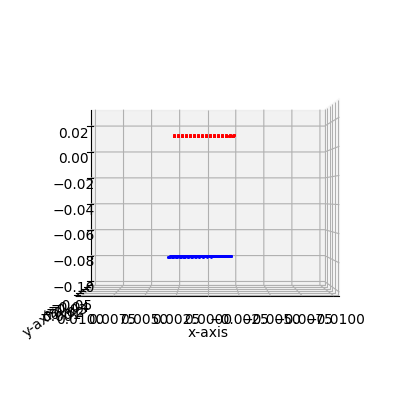

In [27]:
vis(0, 90)

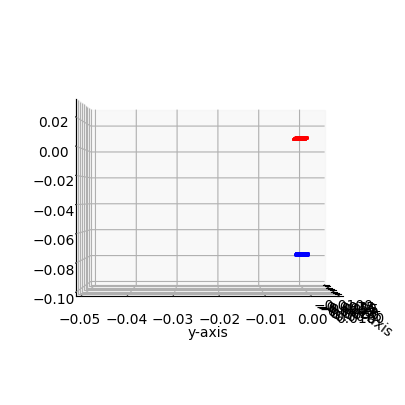

In [28]:
vis(0, 0)